<a id='start'></a>

# Рекомендация тарифов

Имеем дело с данными о поведении клиентов, которые перешли на новые тарифы сотового оператора. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных проведена ранее.

Необходимо построить модель с максимально большим значением *accuracy* (>0.75). <br><br>

**Цель исследования:**<br>
Подготовить модель, которая будет способна определять какой из новых тарифов предложить пользователю; какой из новых тарифов ему больше подойдет.

**Задачи исследования:**
1. [Изучить данные;](#step1)
2. [Поделить данные на выборки: тренировочную, на которой модель будем обучать; валидационную, на основе которой будем подбирать гиперпараметры; тестовую, на которой будем проверять качество полученной модели;](#step2)
3. [Исследовать модели - различные алгоритмы классификации; выбрать наилучшую путем варьирования гиперпараметров и определением метрики качества accuracy;](#step3)
4. [Проверить качество выбранной модели на тестовой выборке. Критерий качества: accuracy не должно быть меньше 0.75;](#step4)
5. [Проверить модель на адекватность;](#step5)
6. [Сделать выводы.](#step6)

## Изучение данных <a id='step1'></a>

Импорт библиотек:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

Проверка данных:

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Итак, признаки для обучения:<br>
1. сalls — количество звонков;
2. minutes — суммарная длительность звонков в минутах;
3. messages — количество sms-сообщений;
4. mb_used — израсходованный интернет-трафик в Мб.

Целевой признак: is_ultra — каким тарифом пользовался клиент в течение месяца («Ультра» — 1, «Смарт» — 0).

Посмотрим на сбалансированность классов в столбце с целевым признаком "is_ultra"

In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [5]:
len(df.loc[df['is_ultra']==0])//len(df.loc[df['is_ultra']==1])

2

Клиентов с тарифом "Смарт" примерно в 2 раза больше, т.е. соотношение значений 0 и 1 в толбце примерно 1:2

Посмотрим на корреляцию признаков в датасете

In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Неожиданностей нет, есть очевидная зависимость количества звонков от суммарной длительности звонков.


## Деление данных на выборки <a id='step2'></a>

Разобьем данные на выборки: тренировочную, на которой модель будем обучать; валидационную, на основе которой будем подбирать гиперпараметры; тестовую, на которой будем проверять качество полученной модели.<br>
Сначала данные разобьем на две части: 80% тренировочных данных, 20% - тестовая выборка.<br>
Далее тренировочные данные разобъем следующим образом: четверть выделим на валидационную выборку, остальное оставим для обучения.<br>
Таким образом, разбиваем полученные данные следующим образом: 60% - обучающая выборка; 20% - валидационная выборка; 20% - тестовая выборка.

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345, stratify=df['is_ultra'])
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345, stratify=df_train['is_ultra'])

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [8]:
df.shape

(3214, 5)

In [9]:
df_train.shape

(1928, 5)

In [10]:
df_test.shape

(643, 5)

In [11]:
df_valid.shape

(643, 5)

## Исследование моделей <a id='step3'></a>

Исследуем модель "Решающее дерево". Найдем наилучшее значение гиперпараметра глубины дерева max_depth, определяя метрику качества accuracy. Наиболее качественной будет модель с самым высоким значением accuracy.

In [12]:
best_model_tree = None
best_result_tree = 0
best_depth = 0
depth_plot = []
result_plot = []
for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions) 
    print(f'max_depth = {depth} : {result}')
    
    depth_plot.append(depth)
    result_plot.append(result)
    
    if result > best_result_tree:
        best_model_tree = model 
        best_result_tree = result 
        best_depth = depth 
        
print('Accuracy наилучшей модели на валидационной выборке:', best_result_tree)
print('Глубина:', best_depth)

max_depth = 1 : 0.7589424572317263
max_depth = 2 : 0.7838258164852255
max_depth = 3 : 0.8040435458786936
max_depth = 4 : 0.8040435458786936
max_depth = 5 : 0.8164852255054432
max_depth = 6 : 0.80248833592535
max_depth = 7 : 0.807153965785381
max_depth = 8 : 0.8055987558320373
max_depth = 9 : 0.8118195956454122
max_depth = 10 : 0.8055987558320373
Accuracy наилучшей модели на валидационной выборке: 0.8164852255054432
Глубина: 5


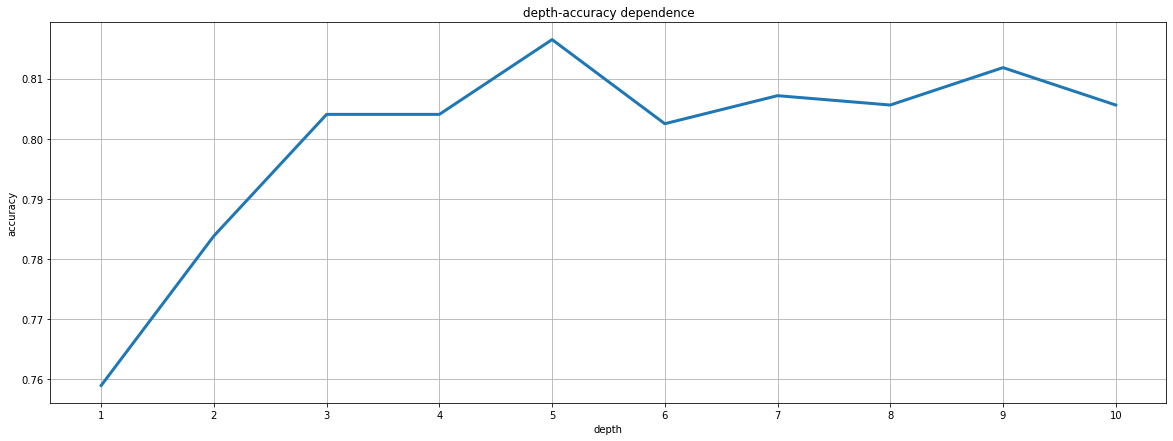

In [22]:
plt.plot(depth_plot, result_plot, linewidth=3)
plt.rcParams['figure.figsize'] = [20, 7]
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.title('depth-accuracy dependence')
plt.grid()
plt.xticks(depth_plot)
plt.show()

Из графика видно, что наилучшая точность достигается при глубине дерева, равной 5.

Как решение принимает модель:

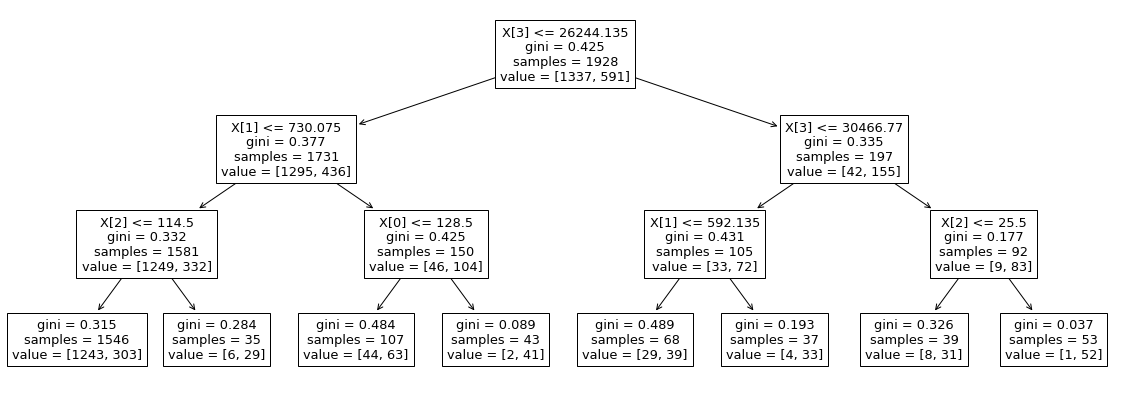

In [14]:
model = DecisionTreeClassifier(random_state=12345, max_depth=3)
tree.plot_tree(model.fit(features_train, target_train))
plt.show()

Следующая модель: "Случайный лес". Найдем наилучшее значение гиперпараметра количества деревьев n_estimators, определяя метрику качества accuracy. Наиболее качественной будет модель с самым высоким значением accuracy. Максимальную глубину деревьев max_depth задавать не будем.

In [24]:
best_model_forest = None
best_result_forest = 0
best_est = 0
for est in tqdm(range(1, 16)):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid) 
        print(f'est = {est} : {result}, max_depth = {depth}')
        if result > best_result_forest:
            best_model_forest = model 
            best_result_forest = result
            best_est = est 
            best_depth = depth
    print()

print('Accuracy наилучшей модели на валидационной выборке:', best_result_forest)
print('Количество деревьев:', best_est)
print('Глубина:', best_depth)



 13%|█▎        | 2/15 [00:00<00:01, 11.93it/s]

est = 1 : 0.7433903576982893, max_depth = 1
est = 1 : 0.7807153965785381, max_depth = 2
est = 1 : 0.7744945567651633, max_depth = 3
est = 1 : 0.7682737169517885, max_depth = 4
est = 1 : 0.7993779160186625, max_depth = 5
est = 1 : 0.7900466562986003, max_depth = 6
est = 1 : 0.7931570762052877, max_depth = 7
est = 1 : 0.7947122861586314, max_depth = 8
est = 1 : 0.7947122861586314, max_depth = 9
est = 1 : 0.744945567651633, max_depth = 10

est = 2 : 0.7418351477449455, max_depth = 1
est = 2 : 0.7807153965785381, max_depth = 2
est = 2 : 0.776049766718507, max_depth = 3
est = 2 : 0.7744945567651633, max_depth = 4
est = 2 : 0.7900466562986003, max_depth = 5
est = 2 : 0.7900466562986003, max_depth = 6
est = 2 : 0.8055987558320373, max_depth = 7
est = 2 : 0.8087091757387247, max_depth = 8
est = 2 : 0.7838258164852255, max_depth = 9
est = 2 : 0.744945567651633, max_depth = 10

est = 3 : 0.7418351477449455, max_depth = 1
est = 3 : 0.7838258164852255, max_depth = 2
est = 3 : 0.776049766718507, ma

 27%|██▋       | 4/15 [00:00<00:01,  8.10it/s]

est = 4 : 0.8164852255054432, max_depth = 8
est = 4 : 0.8133748055987559, max_depth = 9
est = 4 : 0.7916018662519441, max_depth = 10

est = 5 : 0.7527216174183515, max_depth = 1
est = 5 : 0.7558320373250389, max_depth = 2
est = 5 : 0.7931570762052877, max_depth = 3
est = 5 : 0.7900466562986003, max_depth = 4
est = 5 : 0.8227060653188181, max_depth = 5
est = 5 : 0.8164852255054432, max_depth = 6
est = 5 : 0.8211508553654744, max_depth = 7
est = 5 : 0.8242612752721618, max_depth = 8
est = 5 : 0.8133748055987559, max_depth = 9


 40%|████      | 6/15 [00:00<00:01,  6.40it/s]

est = 5 : 0.8118195956454122, max_depth = 10

est = 6 : 0.7527216174183515, max_depth = 1
est = 6 : 0.7651632970451011, max_depth = 2
est = 6 : 0.7947122861586314, max_depth = 3
est = 6 : 0.7931570762052877, max_depth = 4
est = 6 : 0.8227060653188181, max_depth = 5
est = 6 : 0.8149300155520995, max_depth = 6
est = 6 : 0.8195956454121306, max_depth = 7
est = 6 : 0.8258164852255054, max_depth = 8
est = 6 : 0.8133748055987559, max_depth = 9
est = 6 : 0.807153965785381, max_depth = 10



 47%|████▋     | 7/15 [00:01<00:01,  5.75it/s]

est = 7 : 0.7511664074650077, max_depth = 1
est = 7 : 0.7698289269051322, max_depth = 2
est = 7 : 0.7962674961119751, max_depth = 3
est = 7 : 0.80248833592535, max_depth = 4
est = 7 : 0.8164852255054432, max_depth = 5
est = 7 : 0.8118195956454122, max_depth = 6
est = 7 : 0.8211508553654744, max_depth = 7
est = 7 : 0.8273716951788491, max_depth = 8
est = 7 : 0.8164852255054432, max_depth = 9
est = 7 : 0.8195956454121306, max_depth = 10

est = 8 : 0.7511664074650077, max_depth = 1
est = 8 : 0.7729393468118196, max_depth = 2
est = 8 : 0.7931570762052877, max_depth = 3
est = 8 : 0.8164852255054432, max_depth = 4
est = 8 : 0.8180404354587869, max_depth = 5
est = 8 : 0.8164852255054432, max_depth = 6
est = 8 : 0.8227060653188181, max_depth = 7
est = 8 : 0.8242612752721618, max_depth = 8


 53%|█████▎    | 8/15 [00:01<00:01,  4.91it/s]

est = 8 : 0.8164852255054432, max_depth = 9
est = 8 : 0.8227060653188181, max_depth = 10

est = 9 : 0.749611197511664, max_depth = 1
est = 9 : 0.7698289269051322, max_depth = 2
est = 9 : 0.8009331259720062, max_depth = 3
est = 9 : 0.8180404354587869, max_depth = 4
est = 9 : 0.8195956454121306, max_depth = 5
est = 9 : 0.8195956454121306, max_depth = 6


 60%|██████    | 9/15 [00:01<00:01,  4.47it/s]

est = 9 : 0.8227060653188181, max_depth = 7
est = 9 : 0.8304821150855366, max_depth = 8
est = 9 : 0.8180404354587869, max_depth = 9
est = 9 : 0.8164852255054432, max_depth = 10

est = 10 : 0.7511664074650077, max_depth = 1
est = 10 : 0.7822706065318819, max_depth = 2
est = 10 : 0.7931570762052877, max_depth = 3
est = 10 : 0.8211508553654744, max_depth = 4


 67%|██████▋   | 10/15 [00:01<00:01,  4.10it/s]

est = 10 : 0.8149300155520995, max_depth = 5
est = 10 : 0.8149300155520995, max_depth = 6
est = 10 : 0.8195956454121306, max_depth = 7
est = 10 : 0.8320373250388803, max_depth = 8
est = 10 : 0.8211508553654744, max_depth = 9
est = 10 : 0.8102643856920684, max_depth = 10

est = 11 : 0.7542768273716952, max_depth = 1
est = 11 : 0.7993779160186625, max_depth = 2
est = 11 : 0.7869362363919129, max_depth = 3
est = 11 : 0.8164852255054432, max_depth = 4
est = 11 : 0.8133748055987559, max_depth = 5
est = 11 : 0.8118195956454122, max_depth = 6
est = 11 : 0.8180404354587869, max_depth = 7
est = 11 : 0.8227060653188181, max_depth = 8


 73%|███████▎  | 11/15 [00:02<00:01,  3.75it/s]

est = 11 : 0.8180404354587869, max_depth = 9
est = 11 : 0.8087091757387247, max_depth = 10

est = 12 : 0.7573872472783826, max_depth = 1
est = 12 : 0.7869362363919129, max_depth = 2
est = 12 : 0.7900466562986003, max_depth = 3
est = 12 : 0.8149300155520995, max_depth = 4
est = 12 : 0.8149300155520995, max_depth = 5


 80%|████████  | 12/15 [00:02<00:00,  3.40it/s]

est = 12 : 0.8133748055987559, max_depth = 6
est = 12 : 0.8195956454121306, max_depth = 7
est = 12 : 0.8195956454121306, max_depth = 8
est = 12 : 0.8133748055987559, max_depth = 9
est = 12 : 0.8164852255054432, max_depth = 10

est = 13 : 0.7542768273716952, max_depth = 1
est = 13 : 0.7993779160186625, max_depth = 2
est = 13 : 0.8149300155520995, max_depth = 3
est = 13 : 0.8149300155520995, max_depth = 4
est = 13 : 0.8118195956454122, max_depth = 5
est = 13 : 0.8149300155520995, max_depth = 6


 87%|████████▋ | 13/15 [00:02<00:00,  3.09it/s]

est = 13 : 0.8242612752721618, max_depth = 7
est = 13 : 0.8211508553654744, max_depth = 8
est = 13 : 0.8195956454121306, max_depth = 9
est = 13 : 0.8133748055987559, max_depth = 10

est = 14 : 0.7573872472783826, max_depth = 1
est = 14 : 0.7931570762052877, max_depth = 2
est = 14 : 0.8118195956454122, max_depth = 3
est = 14 : 0.8180404354587869, max_depth = 4
est = 14 : 0.8133748055987559, max_depth = 5
est = 14 : 0.8149300155520995, max_depth = 6
est = 14 : 0.8227060653188181, max_depth = 7


 93%|█████████▎| 14/15 [00:03<00:00,  2.76it/s]

est = 14 : 0.8273716951788491, max_depth = 8
est = 14 : 0.8164852255054432, max_depth = 9
est = 14 : 0.8102643856920684, max_depth = 10

est = 15 : 0.7573872472783826, max_depth = 1
est = 15 : 0.7962674961119751, max_depth = 2
est = 15 : 0.8149300155520995, max_depth = 3
est = 15 : 0.8180404354587869, max_depth = 4
est = 15 : 0.8102643856920684, max_depth = 5
est = 15 : 0.8164852255054432, max_depth = 6
est = 15 : 0.8211508553654744, max_depth = 7
est = 15 : 0.8180404354587869, max_depth = 8


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

est = 15 : 0.8164852255054432, max_depth = 9
est = 15 : 0.8118195956454122, max_depth = 10

Accuracy наилучшей модели на валидационной выборке: 0.8320373250388803
Количество деревьев: 10
Глубина: 8


Следующая модель: "Логистическая регрессия".

In [16]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid)
print("Accuracy:", result)

Accuracy: 0.7558320373250389


Сравнивая полученые модели, можно сделать вывод, что наиболее качественной получилась модель "Решающее дерево" с количеством деревьев, равным 10. Accuracy в этом случае получилась равной 0.83, это означает, что на валидационной выборке модель дала 83% правильных ответов. Далее работаем с описанной моделью:

In [17]:
model = best_model_forest

## Проверка модели на тестовой выборке <a id='step4'></a>

Проверим выбранную модель на тестовой выборке:

In [18]:
result = model.score(features_test, target_test)
print("Accuracy:", result)

model.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
result = model.score(features_test, target_test)
print("Accuracy(train+valid):", result)

Accuracy: 0.8102643856920684
Accuracy(train+valid): 0.8149300155520995


Accuracy осталась примерно на том же уровне, модель работоспособна.

## Проверка модели на адекватность <a id='step5'></a>

Сравним полученную модель с примитивной моделью

In [21]:
dummy_model = DummyClassifier()
dummy_model.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
result = dummy_model.score(features_test, target_test)
print('Accuracy:', result)
print('Predict every time:', np.unique(dummy_model.predict(features_test)))

Accuracy: 0.6936236391912908
Predict every time: [0]


Имеем несбалансированные данные, соотношение количества одного класса к другому 1:2. То есть, если мы будем предсказывать в каждом случае самый частый класс (в нашем случае "0"), то с какой-то частотой мы будем делать правильное предсказание.<br>
Итак, полученная модель, предсказывающая всегда "0", имеет значение метрики accuracy около 0.7, значит она делает правильное предсказание в 70% случаев (всего на 5% меньше логистической регрессии).<br>
Сравнивая с нашей выбранной моделью (RF), можем сказать что она адекватна, так как точность ее предсказаний выше (примерно на 11 процентов) точности предсказаний примитивной модели.

## Заключение <a id='step6'></a>

Данные были разбиты на тренировочную, валидационную и тестовую выборки. На тренировочной выборке модели обучались, на валидационной - изучалось качество моделей с различными гиперпараметрами, на тестовой - проверялось качество выбранной модели.

В проекте были исследованы три модели классификации: Решающее дерево, Случайный лес, Логистическая регрессия.

Исследовалась метрика качества Accuracy, соответствующая доле правильных ответов, которая дает модель.

По итогам исследования набольшее количество правильных ответов дала модель "Случайный лес" с количеством деревьем, равным 10, и глубиной 8. Accuracy получилась равной около 0.83, что подтвердилось и на тестовой выборке (на тестовой получили около 0.81). 

Модель была проверена на адекватность, сравнивалась с примитивной моделью. Модель оказалась адекватной.

В итоге была подготовлена модель, которая способная определять какой из новых тарифов стоит предложить пользователю; какой из новых тарифов ему больше подойдет с точностью 81%.

<br>

[В начало](#start)